In [1]:
import pandas as pd 
import numpy as np 

In [2]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
from data_clean_for_model import data_clean_for_model

In [4]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 50)
np.set_printoptions(suppress=True)

In [5]:
df = pd.read_parquet("data/all_processed_df.parquet.gzip")

In [6]:
# add outcome var + unique id 
df['outcome'] = np.where(df['state']=="successful", 1, 0)
df['un_id'] = np.arange(0, df.shape[0], 1)
df['name_len'] = df['name'].str.len()

In [7]:
clean_params = {
    'lnom_frac':0.3, 
    'test_frac':0.25, 
    'lnom_usdgoal':True,
    'rseed': 229,
}
X_train, X_test, y_train, y_test = data_clean_for_model(df, "outcome", clean_params)

In [17]:
print("Train shape:", X_train.shape)
print("Test shape:",  X_test.shape)

Train shape: (116154, 17)
Test shape: (38719, 17)


In [8]:
X_train.head()

,blurb_len,name_len,usd_goal,deadline,launched_at,currency_outcome_mean,country_outcome_mean,cat_id_outcome_mean,cat_parent_id_outcome_mean,loc_id_outcome_mean,loc_type_outcome_mean,currency_usd_goal_mean,country_usd_goal_mean,cat_id_usd_goal_mean,cat_parent_id_usd_goal_mean,loc_id_usd_goal_mean,loc_type_usd_goal_mean
0,132.0,11,74000.00000,1429048654,1427752693,0.610658,0.610658,0.601838,0.285426,0.601838,0.601891,-0.578951,-0.578951,-0.542368,-0.783097,-0.542368,-0.636200
1,124.0,37,374.00000,1604507962,1601912362,0.610658,0.610658,0.922182,0.613145,0.601838,0.601891,4.705957,4.705957,2.290331,3.839845,4.742540,4.648708
2,133.0,30,30000.00000,1428172967,1424288567,0.610658,0.610658,0.601838,0.668641,0.601838,0.601891,0.323897,0.323897,0.360480,-1.065535,0.360480,0.266648
3,119.0,37,3992.62165,1536531606,1533939606,0.595527,0.595527,0.601838,0.713855,0.601838,0.601891,1.720210,1.720210,2.377012,0.942013,2.377012,2.283180
4,125.0,25,10000.00000,1612398240,1607926242,0.610658,0.610658,0.601838,0.601838,0.601838,0.601891,1.422443,1.422443,1.459026,1.459026,1.459026,1.365193


In [15]:
model_params = {
    'rseed':229
}

In [9]:
# withou any parameters
clf = lgb.LGBMClassifier(random_state=model_params['rseed'])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

accuracy 0.7451897001472145
              precision    recall  f1-score   support

           0       0.71      0.63      0.66     15514
           1       0.77      0.83      0.80     23205

    accuracy                           0.75     38719
   macro avg       0.74      0.73      0.73     38719
weighted avg       0.74      0.75      0.74     38719

[[ 9699  5815]
 [ 4051 19154]]


In [10]:
# with some params, haven't tuned yet though really
clf = lgb.LGBMClassifier(
    num_leaves = 100, 
    min_data_in_leaf = 50, 
    max_depth = 15, 
    feature_fraction = 0.75, 
    max_bin=200, 
    #learning_rate=0.03,
    lambda_l1=0.75, 
    lambda_l2=0.5,
    random_state=model_params['rseed']
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0.75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.75
accuracy 0.7487280146698003
              precision    recall  f1-score   support

           0       0.71      0.63      0.67     15514
           1       0.77      0.83      0.80     23205

    accuracy                           0.75     38719
   macro avg       0.74      0.73      0.73     38719
weighted avg       0.75      0.75      0.75     38719

[[ 9845  5669]
 [ 4060 19145]]


In [11]:
# add naive bayes preds 
nb_proba_train = np.load("data/res/multi_nb_preds_train.npy")
nb_proba_test = np.load("data/res/multi_nb_preds_test.npy")
X_train_nb = X_train.copy()
X_test_nb = X_test.copy()
X_train_nb['nb_proba'] = nb_proba_train[:, 1]
X_test_nb['nb_proba'] = nb_proba_test[:, 1]

In [12]:
clf = lgb.LGBMClassifier(
    num_leaves = 100, 
    min_data_in_leaf = 50, 
    max_depth = 15, 
    feature_fraction = 0.75, 
    max_bin=200, 
    #learning_rate=0.03,
    lambda_l1=0.75, 
    lambda_l2=0.5,
    random_state=model_params['rseed']
)
clf.fit(X_train_nb, y_train)
y_pred = clf.predict(X_test_nb)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0.75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.75
accuracy 0.7618998424546088
              precision    recall  f1-score   support

           0       0.73      0.65      0.69     15514
           1       0.78      0.84      0.81     23205

    accuracy                           0.76     38719
   macro avg       0.75      0.74      0.75     38719
weighted avg       0.76      0.76      0.76     38719

[[10122  5392]
 [ 3827 19378]]


In [13]:
w2v_train = np.load("data/res/w2v_Xtrain_avg.npy")
w2v_test = np.load("data/res/w2v_Xtest_avg.npy")
X_train_nb_w2v = pd.concat((X_train_nb, pd.DataFrame(w2v_train)), axis=1)
X_test_nb_w2v = pd.concat((X_test_nb, pd.DataFrame(w2v_test)), axis=1)

In [16]:
clf = lgb.LGBMClassifier(
    num_leaves = 200, 
    min_data_in_leaf = 50, 
    max_depth = 25, 
    feature_fraction = 0.75, 
    max_bin=400, 
    #learning_rate=0.03,
    lambda_l1=0.75, 
    lambda_l2=0.5,
    is_unbalance=True,
    random_state=model_params['rseed']
)
clf.fit(X_train_nb_w2v, y_train)
y_pred = clf.predict(X_test_nb_w2v)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0.75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.75
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
accuracy 0.7623905576073762
              precision    recall  f1-score   support

           0       0.70      0.70      0.70     15514
           1       0.80      0.80      0.80     23205

    accuracy                           0.76     38719
   macro avg       0.75      0.75      0.75     38719
weighted avg       0.76      0.76      0.76     38719

[[10880  4634]
 [ 4566 18639]]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

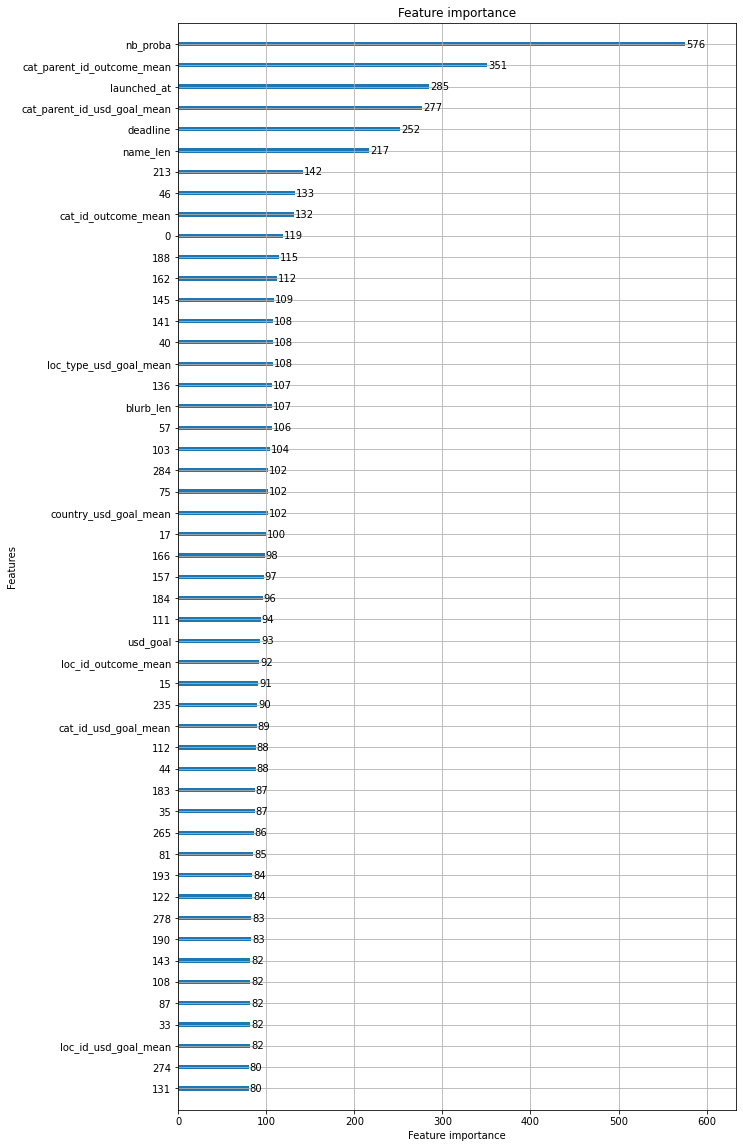

In [18]:
lgb.plot_importance(clf, max_num_features=50, figsize=(10,20))